# 4 - Create Figure 3 (worldmap) and simpler variants of it

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.cluster import KMeans

import moepy
import oggm
from oggm import utils
from help_functions import cmap, scaler
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature


DATE = 'Feb12_2024'

In [3]:
df_rgi6g = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
df_rgi6g = df_rgi6g.loc[df_rgi6g.Connect != 2]

df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
rgidf_dict = {}
rgidf_vol = {}
rgidf_vol_all = 0
slope_avg_d = {}
rgi_regs = list(df_rgi6g['O1Region'].unique())
for rgi_reg in rgi_regs:
    rgidf = df_rgi6g.loc[df_rgi6g.O1Region == rgi_reg]
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    
    rgidf_vol[rgi_reg] = df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].sum()
    rgidf_vol_all += df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].sum()
    slope_avg = np.average(rgidf['Slope'], weights=df_itmix.loc[rgidf_dict[rgi_reg].index]['vol_itmix_m3'].values)
    slope_avg_d[rgi_reg] = slope_avg
pd_rel_vol = (100*pd.DataFrame(index=['vol_relperc_itmix'],data=rgidf_vol)/rgidf_vol_all).T
np.testing.assert_allclose(pd_rel_vol.sum(), 100)

In [4]:
exp_decay = False
if exp_decay:
    add= '_temp_above_0_8'

    ##############these files have not been updated, but that does not matter, as we don't use them anymore,
    # just leave it here in case, we use them again -> would also need to update the filepaths... 
    #pd_exp_decay_fits_adv = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_complex_20yr_avg_period{add}.csv', index_col=0)
    pd_exp_decay_fits_simple = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period{add}_current12deg.csv', index_col=0)
    # actually for the fits of 100/500 years, it is better to use more data below 1.2°C (as they are mainly used to get values for 1.2°C!!!)
    pd_exp_decay_fits_simple_all_exp = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period_current12deg.csv', index_col=0)

    # also include directly the clusters ... 
    pd_exp_decay_fits_simple_5000 = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period{add}_current12deg_5000_w_kmeansclusters.csv', index_col=0)
    pd_exp_decay_fits_simple_5000_all_exp = pd.read_csv(f'fitted_glacier_response_to_global_temp_ch_simple_20yr_avg_period_current12deg_5000_w_kmeansclusters.csv', index_col=0)
    df = pd_exp_decay_fits_simple_5000.copy()

    current_deltaT = 1.2
    def exponential_decay(x, a, b):
        exp_values_b = -b *(x-current_deltaT)
        return a * np.exp(exp_values_b) #+ c * np.exp(exp_values_d)#**c 

**Attention:** you need to download the GlacierMIP3/data/data_from_others folder from the OGGM cluster (https://cluster.klima.uni-bremen.de/~lschuster/GlacierMIP3/data/data_from_others), and copy this folder into your data folder to run the code below:

In [5]:
rgi_shp_fn = '../data/data_from_others/rgi60_all_simplified2_robinson.shp'
rgi_regions_fn = '../data/data_from_others/rgi60_regions_robinson-v2.shp'

In [6]:
def reg_pie_subplot(reg = 'All', ax =None, leg = False, only_steady_state=False,
                    temp_above_0_8_for_ss=False, lowess_fit = False, rel_to = '_rel_farinotti',
                    avg_over = '101yr',
                    add = '', #'_fit_to_median',
                    show_perc_value=False, perc_show=90, color_text = True, 
                    temp_above_0_8 = False,
                    temp_levels =[1.2, 5.0],
                    yrs = [100,5000]):
    if reg == 'All':
        _reg = 'Globally'
    else:
        _reg = reg
    shift = 0.5*np.pi
    p_shift = '_shift_years_rel_2020'
    yr = 5000
    if yr == 5000:
        fpath = f'lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv'
    elif yr == 100:
        fpath = f'lowess_fit_rel_2020_21yr_avg_after100yr_{DATE}.csv'
    if lowess_fit:  
        if temp_above_0_8_for_ss:
            add = '_temp_above_0_8'+add            
        #pd_l = pd.read_csv(f'fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_lowess_added_current12deg.csv')
        pd_l = pd.read_csv(f'../data/{fpath}')
        # fitted_lowess_best_frac{p_shift}_101yr_avg_period{add}_lowess_added_quantiles_added_current12deg_{yr}_{DATE}_ipcc_ar6.csv')
        
        pd_l[f'ice_loss{rel_to}'] = 100-pd_l['0.5']
        #pd_l = pd.read_csv(f'fitted_t_lowess_best_frac_{avg_over}_avg_period{add}_lowess_added_current12deg_w_ice_loss.csv', index_col=[0])
        _pd_l_reg = pd_l.loc[pd_l.region == reg]
        pd_l_reg = _pd_l_reg.loc[_pd_l_reg.year == yr]
        pd_l_reg.index = pd_l_reg.temp_ch.round(2)

    else:
        print('Not anymore implemented')
        #if not temp_above_0_8_for_ss:
        #    df = pd_exp_decay_fits_simple_all_exp.loc[pd_exp_decay_fits_simple_all_exp.year==yr]
        #else:
        #    df = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year==yr]

        #pd_sel_reg = df.loc[df.rgi_reg==reg]
        #a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
        
    rot_l = []
    t_l = []
    temp_levels_a = temp_levels[0]
    if len(temp_levels)==1:
        temp_ch_sel_n = np.array([temp_levels_a])  
    else:
        temp_levels_e = temp_levels[-1]
        temp_ch_sel_n = np.arange(temp_levels_a,temp_levels_e+0.05,0.1)  

    colors_fit_n = cmap(scaler.transform(temp_ch_sel_n.reshape(-1,1))) # only every decile ...
    
    for t in temp_ch_sel_n[::-1]: # I want to rather see the lowest temperature than the highest (color) of temperature
        if lowess_fit: 
            f = pd_l_reg.loc[t.round(5), f'ice_loss{rel_to}']
            valsnorm = (f/100)*2*np.pi  #+shift

        else:
            f = exponential_decay(t,a,b)

            valsnorm = (1-((f/100)))*2*np.pi  #+shift

        c=cmap(scaler.transform(t.reshape(-1,1)))
        ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.44, color = c, lw=0.5, alpha = 1)
        if t.round(2) in [1.5,2,2.5, 3,3.5,4,4.5,5]:
            size=0.17
            ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.47, color = c, lw=2, zorder=5)
            rot_l.append(-valsnorm+shift)
            t_l.append(t)
        if t.round(2) in [1.2]:
            ax.bar(x=shift,#valsleft[-1], #[:, 0],
                        width=[0,-valsnorm], #+shift, #10, #valsnorm.sum(axis=1),
                        bottom=0.2, height=0.27,
                        color= c,# blueish colorfrom 
                   edgecolor=c, 
                   #'gainsboro', 
                   linewidth=0,
                   align="edge", alpha =1)
        
        if t.round(2) in [1.2,1.5,2,2.5,3,4,5] and reg == 'All' and leg:
            if t.round(2) == 1.2:
                tt = f'{t.round(1)}°C'
                ha ='left'
                va = 'top'
                s=-0.01
            elif t.round(2)==1.5:
                tt = f'{t.round(1)}'
                ha ='center'
                va = 'top'
                s=0.005 #0.01
            elif t>=4:
                va='bottom'
                ha = 'right'
                tt = f'{t.round(1)}'
                s=-0.025
            elif t.round(2)==2:
                tt = f'{t.round(1)}'
                ha = 'right'
                va = 'center'
                s = 0.015
            else:
                tt = f'{t.round(1)}'
                ha = 'right'
                va = 'center'
                s = 0.005

            ax.text(-valsnorm+shift, 0.477+s, tt, fontsize=11, #11,
                    fontweight='bold',
                    color=c.squeeze(), verticalalignment=va, horizontalalignment=ha) #, horizontalalignment='center')
            
    if lowess_fit and show_perc_value: 
        # we will only use the tenth of degree values
        pd_l_reg_dec = pd_l_reg.loc[np.arange(-0.1,6.9,0.1).round(5)]
        
        t= pd_l_reg_dec.loc[np.abs(pd_l_reg_dec[f'ice_loss{rel_to}']-perc_show).idxmin()].temp_ch.round(1)
        #t = t.values[0]
        assert t.std()==0
        try:
            t = t.index[0]
        except:
            t
        if t<1.2:
            c='darkblue'
        else:
            c=cmap(scaler.transform(t.reshape(-1,1))).squeeze()
        #c = 'grey' #
        if color_text:
            c_t = c
        else:
            c_t = 'black'
        if reg == 'All':
            fs=8# .5 # 10 
            ax.text(0, 0, f'50%\nmass:\n{t.round(1)}°C', # removed >=
                    fontsize=fs,
                color=c_t, verticalalignment='center',horizontalalignment='center', weight='bold')
        else:
            fs =7
            ax.text(0, 0, f'{t.round(1)}', fontsize=fs,
                color=c_t, verticalalignment='center',horizontalalignment='center', weight='bold')

    
    # after 100, 500 years 
    if only_steady_state:
        yrs = [5000]
        lss = ['-']
    else:
        lss = [':','--','-']
        if len(yrs)==2:
            lss = [':','-']

        if not '_rel_2020':
            raise NotImplementedError
    for yr,ls in zip(yrs,lss):
        t = 1.2 # committed 
        if lowess_fit: 
            if rel_to =='_rel_2020':
                #if yr != 5000:
                if yr == 5000:
                    fpath = f'lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv'
                elif yr == 100:
                    fpath = f'lowess_fit_rel_2020_21yr_avg_after100yr_{DATE}.csv'
                pd_lyr = pd.read_csv(f'../data/{fpath}')

                pd_lyr[f'ice_loss{rel_to}'] = 100-pd_lyr['0.5']
                pd_lyr = pd_lyr.loc[pd_lyr.region == reg]
                
            else:
                # not anymore maintained ..... filepath will not work as this approach has been abandoned .. 
                pd_lyr = pd.read_csv(f'lowess_fits/fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_lowess_added_current12deg_w_ice_loss_steady_state_{DATE}_ipcc_ar6.csv',
                           index_col=[0])
                #pd_l = pd.read_csv(f'fitted_t_lowess_best_frac_{avg_over}_avg_period{add}_lowess_added_current12deg_w_ice_loss.csv', index_col=[0])
                pd_lyr = pd_lyr.loc[pd_lyr.region == _reg]
            pd_l_reg = pd_lyr.loc[pd_lyr.year == yr]
            pd_l_reg.index = pd_l_reg.temp_ch.round(2)
            #print(t, pd_l_reg)
            f = pd_l_reg.loc[np.round(t,5), f'ice_loss{rel_to}']
            # here the ice loss is already computed
            valsnorm = (f/100)*2*np.pi  #+shift
                
        else:
            df_yr = pd_exp_decay_fits_simple.loc[pd_exp_decay_fits_simple.year==yr]
            if (yr <5000) or (not temp_above_0_8_for_ss):
                df_yr = pd_exp_decay_fits_simple_all_exp.loc[pd_exp_decay_fits_simple_all_exp.year==yr]
            pd_sel_reg = df_yr.loc[df_yr.rgi_reg==reg]
            #pd_sel_reg = df.loc[df.rgi_reg==reg]
            a,b = pd_sel_reg[['a_simple', 'b_simple']].values.squeeze()
            # here we first estimate the remaining ice
            f = exponential_decay(t,a,b)
            # and from that the ice loss
            valsnorm = (1-((f/100)))*2*np.pi  #+shift
        #print(f)
        c=cmap(scaler.transform(np.array([t]).reshape(-1,1)))
        if yr == 5000:
            lw = 2 #.5
        else:
            lw=1.5 #2
        ax.vlines(x=-valsnorm+shift, ymin=0.2,ymax=0.47, color = 'darkblue',
                  lw=lw, alpha = 0.5, ls = ls)
        
        if reg == 'All' and leg:
            if yr == 5000:
                va='center'
                s=0
                texti = '' #f'\n\n\n\nsteady\n-state'
                d = 0
            elif yr ==500:
                va = 'center'
                s=0.01
                texti = f'after {yr}\n   years'
                d = 0
            else:
                va='center'
                s=-0.043
                texti = f' after\n   {yr}\n     years'
                d = +0.15
            ha='left'
            if not only_steady_state: 
                ax.text(-valsnorm+shift+d, 0.477+s, texti, fontsize=7, #.5,
                        #fontweight='bold',
                        color='darkblue',
                        verticalalignment=va, horizontalalignment=ha) #, horizontalalignment='center')
    ax.vlines(x=shift, ymin=0.2,ymax=0.47, color = 'black',
             lw=2, alpha = 1, ls = '-')
    #ax.invert_xaxis()
    #ax.vlines(shift, color='grey',ymin=0.18,ymax=0.5, lw=1, ls='--', zorder=10)
    #ax.vlines(0, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)
    #ax.vlines(-shift, color='grey',ymin=0.18,ymax=0.5, lw=0.5, ls=':', zorder=10)

    if reg == 'All' and leg:
        if rel_to == '_rel_farinotti':
            ax.set_title('Glacier mass loss\n(rel. to inventory date)', fontsize=8, fontweight='bold')
        else:
            ax.set_title('Committed glacier\nmass loss (rel. to 2020)', fontsize=8.5, fontweight='bold')
            #            ax.set_title('Steady-state glacier\nmass loss (rel. to 2020)', fontsize=8.5, fontweight='bold')

    ax.set_ylim([0,0.47])
        
    
    #ax.axis("off")   # turns off axes
    ax.get_xaxis().set_visible(False)
    #ax.set_facecolor('whitesmoke')
    ax.set_facecolor('gainsboro')

    #ax.set_axisbelow.set_visible(False)
    ax.grid(False)
    #ax.set_xticklabels(['25%', '50%','75%', '100%'])
    #ax.set_xticks(ticks = rot_l,labels=t_l)
    ax.set_yticks([])#.set_visible(False)


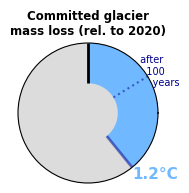

In [7]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='All', ax=ax, leg=True, only_steady_state=False,
                temp_above_0_8_for_ss=False, lowess_fit = True,
                temp_levels =[1.2],
                rel_to = '_rel_2020', show_perc_value=False, perc_show=50, color_text=False,yrs=[100,5000]) #, yrs=[50,300,5000])


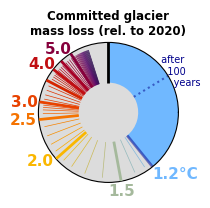

In [8]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='All', ax=ax, leg=True, only_steady_state=False,
                temp_above_0_8_for_ss=False, lowess_fit = True,
                temp_levels =[1.2, 6.8],
                rel_to = '_rel_2020', show_perc_value=False, perc_show=50, color_text=False,yrs=[100,5000]) #, yrs=[50,300,5000])


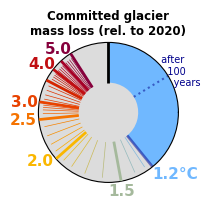

In [9]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='All', ax=ax, leg=True, only_steady_state=False,
                temp_above_0_8_for_ss=False, lowess_fit = True,
                rel_to = '_rel_2020', show_perc_value=False, perc_show=50, color_text=False,yrs=[100,5000]) #, yrs=[50,300,5000])


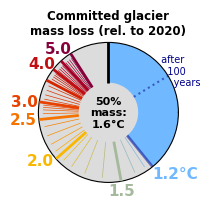

In [10]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='All', ax=ax, leg=True, only_steady_state=False,
                temp_above_0_8_for_ss=False, lowess_fit = True,
                rel_to = '_rel_2020', show_perc_value=True, perc_show=50, color_text=False,yrs=[100,5000]) #, yrs=[50,300,5000])


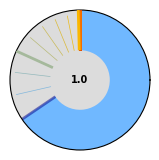

In [11]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='08', ax=ax, leg=True, only_steady_state=True,
                temp_above_0_8_for_ss=False, lowess_fit = True,
                rel_to = '_rel_2020', show_perc_value=True, perc_show=50, color_text=False) #, yrs=[50,300,5000])


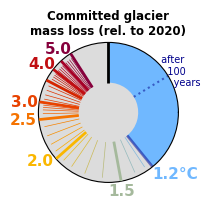

In [12]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='All', ax=ax, leg=True, only_steady_state=False,
                #temp_above_0_8_for_ss=True, 
                lowess_fit = True,
                rel_to = '_rel_2020', show_perc_value=False, perc_show=50) #, yrs=[50,300,5000])


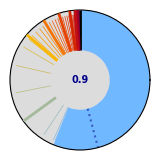

In [13]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_axes([0,0.15,1,0.7], projection='polar')
reg_pie_subplot(reg='11', ax=ax, leg=True, only_steady_state=False,
                temp_above_0_8_for_ss=False, lowess_fit = True, rel_to = '_rel_2020',
                show_perc_value=True, perc_show=50, yrs=[100])


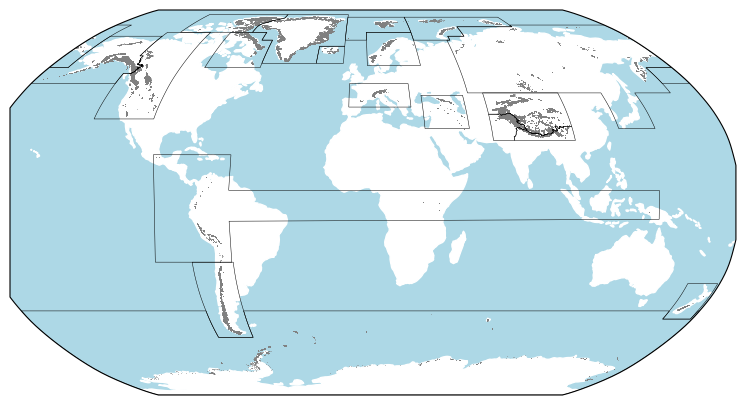

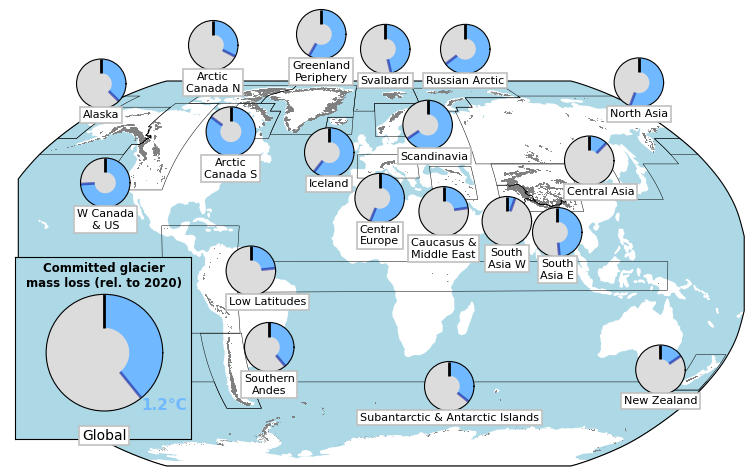

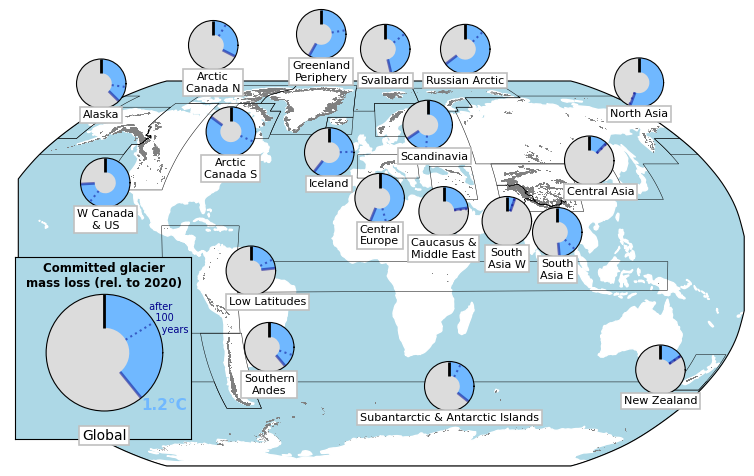

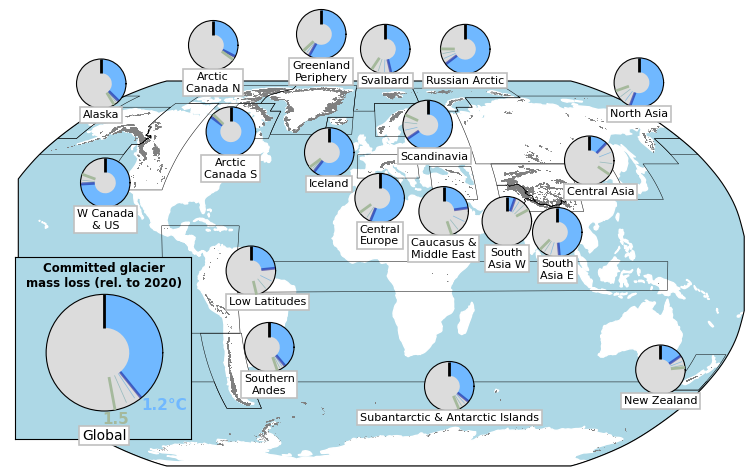

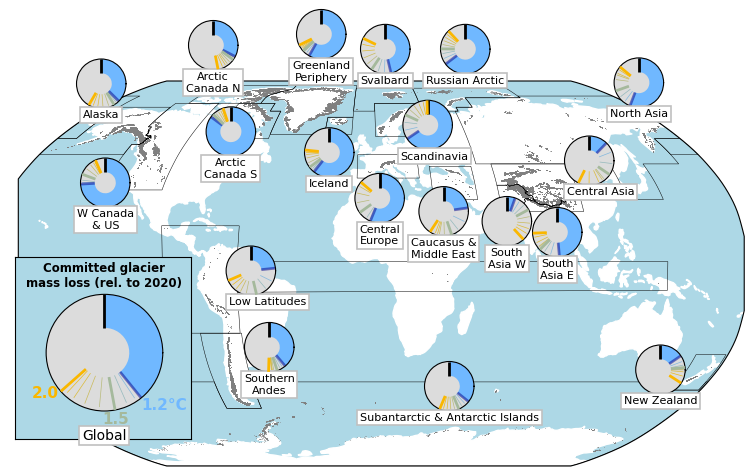

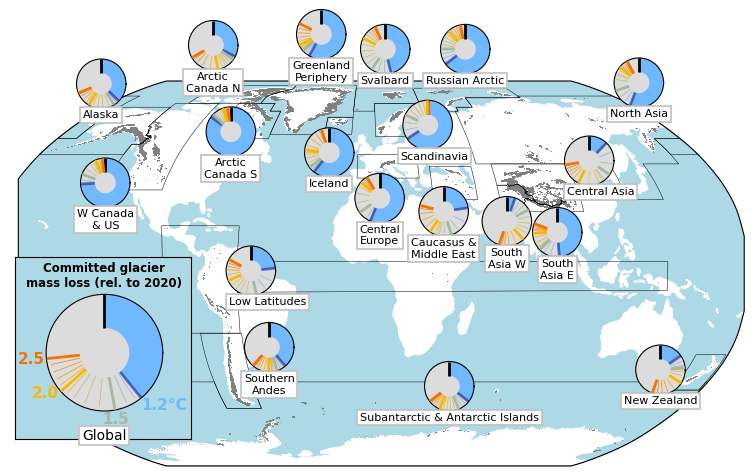

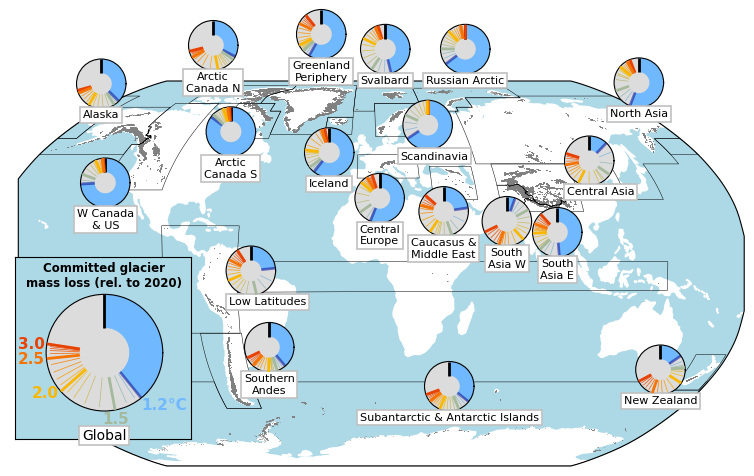

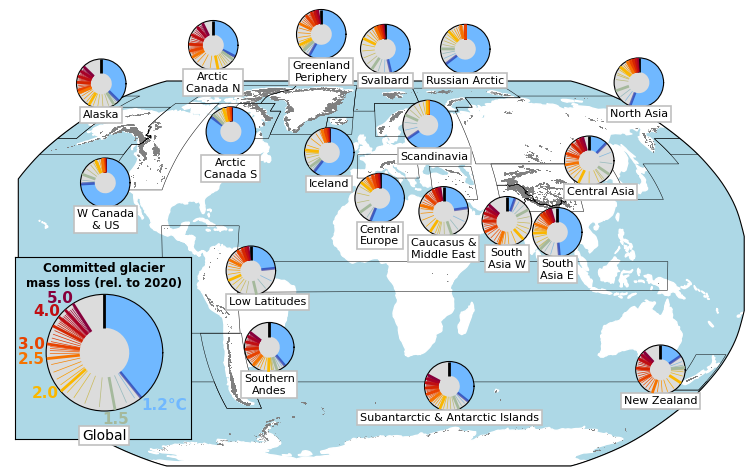

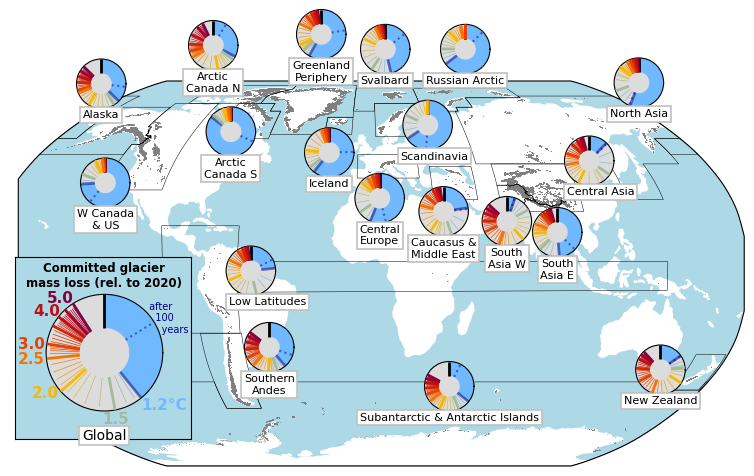

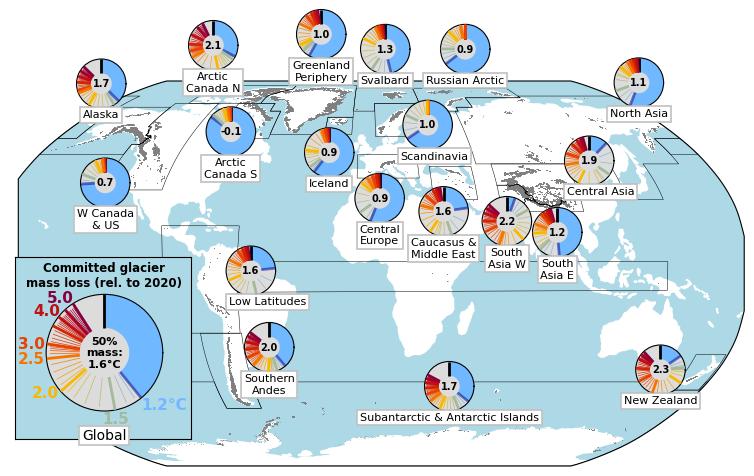

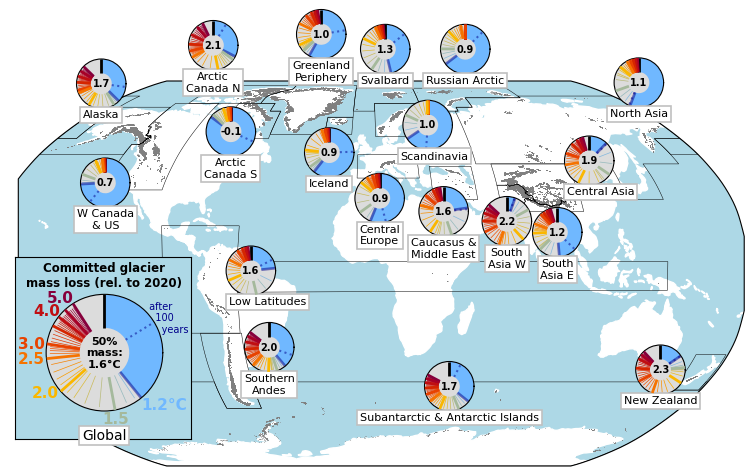

In [14]:
pd_rgi_stats_w_hugonnet = pd.read_csv('../data/3_shift_summary_region_characteristicsFeb12_2024.csv', index_col=[0])

for var_fig in ['_var0', '_var1'
               , '_var1x_a_withyr100','_var1x_b_with1.5','_var1x_b_with2.0','_var1x_b_with2.5',
                '_var1x_b_with3.0','_var2','_var3','_var3b', '_var_final']:
    temp_levels =[1.2, 5.0]
    if var_fig == '_var0':
        only_show_regions = True # fig_v0
        only_steady_state = True #False
        show_perc_value = False
    else:
        only_show_regions = False # fig_v0

    #%% ----- FIGURE: simplified
    if var_fig == '_var1':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2]
    if var_fig == '_var1x_a_withyr100':
        show_perc_value = False #True #True
        only_steady_state = False #False
        temp_levels =[1.2]
    elif var_fig == '_var1x_b_with1.5':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 1.5]
    elif var_fig == '_var1x_b_with2.0':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 2.0]

    elif var_fig == '_var1x_b_with2.5':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 2.5]

    elif var_fig == '_var1x_b_with3.0':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 3.0]

    elif var_fig == '_var2':
        show_perc_value = False #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 5.0]
    elif var_fig == '_var3':
        show_perc_value = False #True #True
        only_steady_state = False #False
        temp_levels =[1.2, 5.0]
    elif var_fig == '_var3b':
        show_perc_value = True #True #True
        only_steady_state = True #False
        temp_levels =[1.2, 5.0]
    elif var_fig == '_var_final':
        show_perc_value = True #True #True
        only_steady_state = False #False
        temp_levels =[1.2, 5.0]

    else:
        pass

    ################# these are usually not changed 
    simple_no_rgi_numbers = True #False
    temp_above_0_8_for_ss=False #False
    lowess_fit = True
    equal_pie_size = True #False 
    color_text = False  ### color text of pies for 50% of the loss 
    ######
    yrs=[100,5000] #[50,300,500, 5000] 
    perc_show = 50

    add_rgi_glaciers = True
    add_rgi_regions = True
    rel_to = '_rel_2020'

    cluster = 'all'
    avg_over = '101yr'
    approach = '_via_5yravg'
    add = '' 


    rgi_reg_fig_dict = {'All':'Global',
                        '01':'01-Alaska',
                        '02':'02-W Canada\n& US',
                        '03':'03-Arctic\nCanada N',
                        '04':'04-Arctic\nCanada S',
                        '05':'05-Greenland\nPeriphery',
                        '06':'06-Iceland',
                        '07':'07-Svalbard',
                        '08':'08-Scandinavia',
                        '09':'09-Russian Arctic',
                        '10':'10-North Asia',
                        '11':'11-Central\nEurope',
                        '12':'12-Caucasus &\nMiddle East',
                        '13':'13-Central Asia',
                        '14':'14-South\nAsia W', # West
                        '15':'15-South\nAsia E', # East
                        '16':'16-Low Latitudes',
                        '17':'17-Southern\nAndes',
                        '18':'18-New Zealand',
                        '19':'19-Subantarctic & Antarctic Islands'
                        }

    pie_scenario = 2

    fig = plt.figure() 

    # Add background image
    ax_background = fig.add_axes([0.0,0.01,1,0.7], projection=ccrs.Robinson()) # 0,0.15,1,0.7 # Why i here RObinson
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
    #    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')



    # Add RGI glacier outlines
    if add_rgi_glaciers:
        # if I do that here: 
        # **somehow only the glaciers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.PlateCarree(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead aplly that here ... 
        ax_background.scatter(df_rgi6g.CenLon.values, df_rgi6g.CenLat.values,
                              facecolor='grey', s=0.25, alpha =0.7, linewidths=0, #0.35,
                              edgecolor='grey',
                              transform=ccrs.PlateCarree(), rasterized=True
                              );

    if add_rgi_regions:
        shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='None',
                                       linewidth=0.35,edgecolor='k')
        ax_background.add_feature(shape_feature)

    if not only_show_regions:

        # Add global boundary
        if equal_pie_size:
            ax_global_patch = fig.add_axes([0.042,0.06,0.22,0.33 #  0.23,0.36
                                       ], facecolor='lightblue')
        else:
            ax_global_patch = fig.add_axes([0.0375,0.06,0.225,0.365 # 255 , 255
                                       ], facecolor='lightblue')  
        ax_global_patch.get_yaxis().set_visible(False)
        ax_global_patch.get_xaxis().set_visible(False)


        regions_ordered = list(rgi_reg_fig_dict.keys())
        reg_pie_sizes = []

        for reg in regions_ordered:
            #reg_slr_cum_pie = stats_overview_df.loc[(stats_overview_df.Region==reg) & (stats_overview_df.Scenario==pie_scenario),'slr_mmSLE_med'].values[0]
            #print(reg, np.round(reg_slr_cum_pie,2))
            #pie_size_min = 0.07
            #if reg_slr_cum_pie > 80:
            #    pie_size = 0.33
            #elif reg_slr_cum_pie > 25:
            #    pie_size = 0.2
            #elif reg_slr_cum_pie < 1:
            #    pie_size = pie_size_min
            #else:
            #    pie_size = pie_size_min + (reg_slr_cum_pie - 1) / (25-1) * (0.2 - pie_size_min)
            if reg == 'All':
                _reg = 'Globally'
                pie_size=0.28
                if equal_pie_size:
                    reg_pie_sizes.append(0.21) # 0.24
                else:
                    reg_pie_sizes.append(pie_size)

            else:
                _reg = reg
                _rel_vol = 100*pd_rgi_stats_w_hugonnet.loc[reg][f'regional_volume_m3_2020{approach}']/pd_rgi_stats_w_hugonnet.loc['All'][f'regional_volume_m3_2020{approach}']
                if _rel_vol > 15:
                    pie_size=0.15
                elif _rel_vol > 5:
                    pie_size=0.13
                elif _rel_vol > 0.5:
                    pie_size=0.11
                else:
                    pie_size=0.09
                if equal_pie_size:
                    reg_pie_sizes.append(0.09)
                else:
                    reg_pie_sizes.append(pie_size)

        add_horizontal_bar = False
        if add_horizontal_bar:
            ax0 = fig.add_axes([0.125,0.18,0.1,0.04], facecolor='none')
            ax1 = fig.add_axes([0.09,0.73,0.1,0.04], facecolor='none')
            ax2 = fig.add_axes([0.13,0.59,0.1,0.04], facecolor='none')
            ax3 = fig.add_axes([0.21,0.875,0.1,0.04], facecolor='none')
            ax4 = fig.add_axes([0.265,0.60,0.1,0.04], facecolor='none')
            ax5 = fig.add_axes([0.34,0.875,0.1,0.04], facecolor='none')
            ax6 = fig.add_axes([0.37,0.64,0.1,0.04], facecolor='none')
            ax7 = fig.add_axes([0.465,0.875,0.1,0.04], facecolor='none')
            ax8 = fig.add_axes([0.573,0.875,0.1,0.04], facecolor='none')
            ax9 = fig.add_axes([0.68,0.875,0.1,0.04], facecolor='none')
            ax10 = fig.add_axes([0.8,0.78,0.1,0.04], facecolor='none')
            ax11 = fig.add_axes([0.44,0.55,0.1,0.04], facecolor='none')
            ax12 = fig.add_axes([0.55,0.535,0.1,0.04], facecolor='none')
            ax13 = fig.add_axes([0.8,0.62,0.1,0.04], facecolor='none')
            ax14 = fig.add_axes([0.655,0.495,0.1,0.04], facecolor='none')
            ax15 = fig.add_axes([0.77,0.47,0.1,0.04], facecolor='none')
            ax16 = fig.add_axes([0.445,0.40,0.1,0.04], facecolor='none')
            ax17 = fig.add_axes([0.36,0.295,0.1,0.04], facecolor='none')
            ax18 = fig.add_axes([0.73,0.3,0.1,0.04], facecolor='none')
            ax19 = fig.add_axes([0.55,0.19,0.1,0.04], facecolor='none')

        # Pie charts
        if equal_pie_size:
            delta = -0.15
            deltan = 0.005
            deltann = 0.002
            #ax0b = fig.add_axes([0.034,0.26+delta,reg_pie_sizes[0],reg_pie_sizes[0]*1.02], facecolor='none',projection="polar")
            ax0b = fig.add_axes([0.049,0.26+delta,reg_pie_sizes[0],reg_pie_sizes[0]*1.01], facecolor='none',projection="polar") ##44
            ax1b = fig.add_axes([0.105,0.81+delta,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none',projection="polar") #0.05,0.735
            ax2b = fig.add_axes([0.11,0.63+delta,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none',projection="polar") #628
            ax3b = fig.add_axes([0.245,0.88+delta,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none',projection="polar") # 255
            ax4b = fig.add_axes([0.267,0.723+delta,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none',projection="polar")
            ax5b = fig.add_axes([0.38,0.90+delta,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none',projection="polar")
            ax6b = fig.add_axes([0.395-deltan,0.685+delta,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none',projection="polar")
            ax7b = fig.add_axes([0.46,0.873+delta,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none',projection="polar")
            ax8b = fig.add_axes([0.518-deltan,0.735+delta,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none',projection="polar")
            ax9b = fig.add_axes([0.56,0.873+delta,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none',projection="polar")
            ax10b = fig.add_axes([0.777,0.812+delta,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none',projection="polar")
            ax11b = fig.add_axes([0.453,0.602+delta,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none',projection="polar")
            ax12b = fig.add_axes([0.533,0.578+delta,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none',projection="polar")  
            ax13b = fig.add_axes([0.715,0.67+delta,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none',projection="polar") #0.735, 0.65
            ax14b = fig.add_axes([0.607+deltan,0.56+delta,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none',projection="polar")
            ax15b = fig.add_axes([0.675,0.54+delta,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none',projection="polar")
            ax16b = fig.add_axes([0.29+deltann,0.47+delta,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none',projection="polar")
            ax17b = fig.add_axes([0.308+deltan+deltann,0.331+delta,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none',projection="polar")
            ax18b = fig.add_axes([0.804,0.29+delta,reg_pie_sizes[18],reg_pie_sizes[18]], facecolor='none',projection="polar")
            ax19b = fig.add_axes([0.54,0.26+delta,reg_pie_sizes[19],reg_pie_sizes[19]], facecolor='none',projection="polar")
        else:
            delta = -0.15
            ax0b = fig.add_axes([0.0245,0.25+delta,reg_pie_sizes[0],reg_pie_sizes[0]], facecolor='none',projection="polar")
            ax1b = fig.add_axes([0.052,0.762+delta,reg_pie_sizes[1],reg_pie_sizes[1]], facecolor='none',projection="polar")
            ax2b = fig.add_axes([0.11,0.628+delta,reg_pie_sizes[2],reg_pie_sizes[2]], facecolor='none',projection="polar")
            ax3b = fig.add_axes([0.205,0.88+delta,reg_pie_sizes[3],reg_pie_sizes[3]], facecolor='none',projection="polar")
            ax4b = fig.add_axes([0.26,0.635+delta,reg_pie_sizes[4],reg_pie_sizes[4]], facecolor='none',projection="polar")
            ax5b = fig.add_axes([0.325,0.90+delta,reg_pie_sizes[5],reg_pie_sizes[5]], facecolor='none',projection="polar")
            ax6b = fig.add_axes([0.37,0.67+delta,reg_pie_sizes[6],reg_pie_sizes[6]], facecolor='none',projection="polar")
            ax7b = fig.add_axes([0.43,0.9+delta,reg_pie_sizes[7],reg_pie_sizes[7]], facecolor='none',projection="polar")
            ax8b = fig.add_axes([0.54,0.9+delta,reg_pie_sizes[8],reg_pie_sizes[8]], facecolor='none',projection="polar")
            ax9b = fig.add_axes([0.63,0.89+delta,reg_pie_sizes[9],reg_pie_sizes[9]], facecolor='none',projection="polar")
            ax10b = fig.add_axes([0.77,0.817+delta,reg_pie_sizes[10],reg_pie_sizes[10]], facecolor='none',projection="polar")
            ax11b = fig.add_axes([0.445,0.597+delta,reg_pie_sizes[11],reg_pie_sizes[11]], facecolor='none',projection="polar")
            ax12b = fig.add_axes([0.538,0.56+delta,reg_pie_sizes[12],reg_pie_sizes[12]], facecolor='none',projection="polar")
            ax13b = fig.add_axes([0.725,0.645+delta,reg_pie_sizes[13],reg_pie_sizes[13]], facecolor='none',projection="polar")
            ax14b = fig.add_axes([0.62,0.527+delta,reg_pie_sizes[14],reg_pie_sizes[14]], facecolor='none',projection="polar")
            ax15b = fig.add_axes([0.70,0.5+delta,reg_pie_sizes[15],reg_pie_sizes[15]], facecolor='none',projection="polar")
            ax16b = fig.add_axes([0.46,0.438+delta,reg_pie_sizes[16],reg_pie_sizes[16]], facecolor='none',projection="polar")
            ax17b = fig.add_axes([0.33,0.331+delta,reg_pie_sizes[17],reg_pie_sizes[17]], facecolor='none',projection="polar")
            ax18b = fig.add_axes([0.812,0.385+delta,reg_pie_sizes[18],reg_pie_sizes[18]], facecolor='none',projection="polar")
            ax19b = fig.add_axes([0.54,0.225+delta,reg_pie_sizes[19],reg_pie_sizes[19]], facecolor='none',projection="polar")


        # ----- Pie Chart of Volume Remaining at steady-state -----
        for nax, ax in enumerate([ax0b, ax1b, ax2b, ax3b, ax4b, ax5b, ax6b, ax7b, ax8b, ax9b, ax10b,
                                  ax11b, ax12b, ax13b, ax14b, ax15b, ax16b, ax17b, ax18b, ax19b]):

            reg = regions_ordered[nax]

            col_line = 'silver'
            lw_line = 1.2

            reg_pie_subplot(reg=reg, ax=ax, leg=True, only_steady_state=only_steady_state, 
                            temp_above_0_8_for_ss=temp_above_0_8_for_ss, rel_to=rel_to, lowess_fit=lowess_fit, 
                            show_perc_value=show_perc_value, perc_show=perc_show,yrs=yrs, color_text=color_text,
                           temp_levels=temp_levels)
            if nax==0:
                v=-0.15
                s = 10
                h=0.5 #0.45
            else:
                v=-0.03
                s=8
                h=0.5
            if (simple_no_rgi_numbers) and (reg != 'All'):
                t = rgi_reg_fig_dict[reg][3:]
            else:
                t = rgi_reg_fig_dict[reg]
            if (nax == 8): ## scandinavia  ä or (nax==17)
                ha = 'left'
                h = -0.05 #-0.05
            elif (nax==13) or (nax ==16):
                ha = 'left'
                h = 0.05 #-0.05
            else:
                ha = 'center'
            ax.text(h, v, t,
                    size=s, horizontalalignment=ha, 
                    verticalalignment='top', transform=ax.transAxes,
                    bbox=dict(facecolor='white', edgecolor=col_line,
                    pad=2, lw=lw_line))
            #ax.axis('equal')   
    #plt.tight_layout()

    fig.set_size_inches(8,5.5) # 8.5
    if only_steady_state:
        addi = '_only_steady_state'
    else:
        addi = ''
    if not temp_above_0_8_for_ss:
        addi = addi + '_fit_over_all_experiments'
    else:
        addi = addi + '_fit_of_steady_state_only_above_0_8'
    if show_perc_value:
        addi = addi + f'_show{perc_show}%'
    if yrs == [50,300,5000]:
        addi = addi +f'_50_300_5000yr'
    if equal_pie_size:
        addi = addi + '_equal_pie_size'
    addi = addi + '_no_cluster_colors'
    if not color_text:
        addi = addi + '_no_colored_text'
    addi = addi + var_fig
    #if not show_all_temp_lev:
    #    addi = addi + '_only_present-day_warming'
    if only_show_regions:
        addi='_only_rgi_regions'
    if cluster == 'all':
        #plt.savefig(f'figures_data_worldmap/lowess_v2{addi}_cluster{k}_{rel_to}_{avg_over}{add}_{DATE}.png', dpi = 600)
        #plt.savefig(f'figures_data_worldmap/lowess_v2{addi}_cluster{k}_{rel_to}_{avg_over}{add}_{DATE}.svg', dpi = 600)
        #plt.savefig(f'figures_data_worldmap/lowess_v2{addi}_cluster{k}_{rel_to}_{avg_over}{add}_{DATE}.pdf', dpi = 600)
        plt.savefig(f'figures/supplements/only_github_supplements/fig3_worldmap_variants/fig3{var_fig}.png', dpi = 600)
        plt.savefig(f'figures/supplements/only_github_supplements/fig3_worldmap_variants/fig3{var_fig}.svg', dpi = 600)
        plt.savefig(f'figures/supplements/only_github_supplements/fig3_worldmap_variants/fig3{var_fig}.pdf', dpi = 600)
    if var_fig == '_var_final':
        plt.savefig(f'figures/fig3.png', dpi = 600)
        plt.savefig(f'figures/fig3.svg', dpi = 600)
        plt.savefig(f'figures/fig3.pdf', dpi = 600)